<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png" alt="alt text" width="400" height="100">

<img src="https://miro.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png" width="900" align="center">

In [1]:
!pip install "pytorch-lightning" "torchmetrics"  -qq

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
import torch.nn.functional as F
from torchvision import transforms

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint

from torchmetrics import Accuracy

import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 40.9 MB/s eta 0:00:00


In [2]:
num_epochs = 20
batch_size = 256

In [3]:
# Create a "composition" (a sequential list) of image transforms
# that will be applied to the images as they are loaded
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])])

# If training with CIFAR10, need to use different mean and standard deviation values!
# transform = transforms.Compose([
#             transforms.Resize(32),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]])


In [4]:
# Create a train and test dataset using the Pytorch MNIST dataloader class
# This inbuilt class will download the MNIST dataset to the provided "root" directory

# Input Parameters:
# root: the directory the dataset is in/should be downloaded to
# train: is this the train split or not? if not it's the test split
# download: if it can't find the dataset in the provided directory should it download the dataset?
# transform: the transform/augmentation to perform on the image data, the images are loaded as PIL images
# at least convert them to tensors (Pytorch has MANY different data augmentations)
dataset_train = MNIST(root='.', train=True,  download=True, transform=transform)
dataset_test  = MNIST(root='.', train=False, download=True, transform=transform)

# can also try the CIFAR10 dataset!
# dataset_train = CIFAR10(root='.', train=True,  download=True, transform=transform)
# dataset_test  = CIFAR10(root='.', train=False, download=True, transform=transform)

# Using the Pytorch dataloader class and the Pytorch datasets with create itterable dataloader objects
data_loader_train = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False)
data_loader_test = DataLoader(dataset_test, shuffle=False, batch_size=batch_size, num_workers=0, pin_memory=False)

# NOTE:num_workers is the number of extra threads the dataloader will spawn to load the data from file,
# rarely need more than 4
# NOTHING SET num_workers TO 0!

# NOTE:pin_memory is only useful if training with a GPU. If it is True then the GPU will pre-allocate
# memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

100%|██████████| 9912422/9912422 [00:00<00:00, 96501878.35it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76814010.03it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 85357138.05it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5253868.94it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
print("Train DataSET size:", len(dataset_train))
print("Test DataSET size:", len(dataset_test))

Train DataSET size: 60000
Test DataSET size: 10000


In [6]:
print("Train DataLOADER size:", len(data_loader_train))
print("Test DataLOADER size:", len(data_loader_test))

Train DataLOADER size: 235
Test DataLOADER size: 40


In [7]:
# The DataLOADER will loop through a batch of indices and provide them to the dataSET one at a time
# and will "batch" together all the datapoints along the "batch dimension" (dim 0) returning a single tensor
train_data_iter = iter(data_loader_train)
data, labels = next(train_data_iter)
print("Input Data shape", data.shape)
print("Target Data shape", labels.shape)

Input Data shape torch.Size([256, 1, 32, 32])
Target Data shape torch.Size([256])


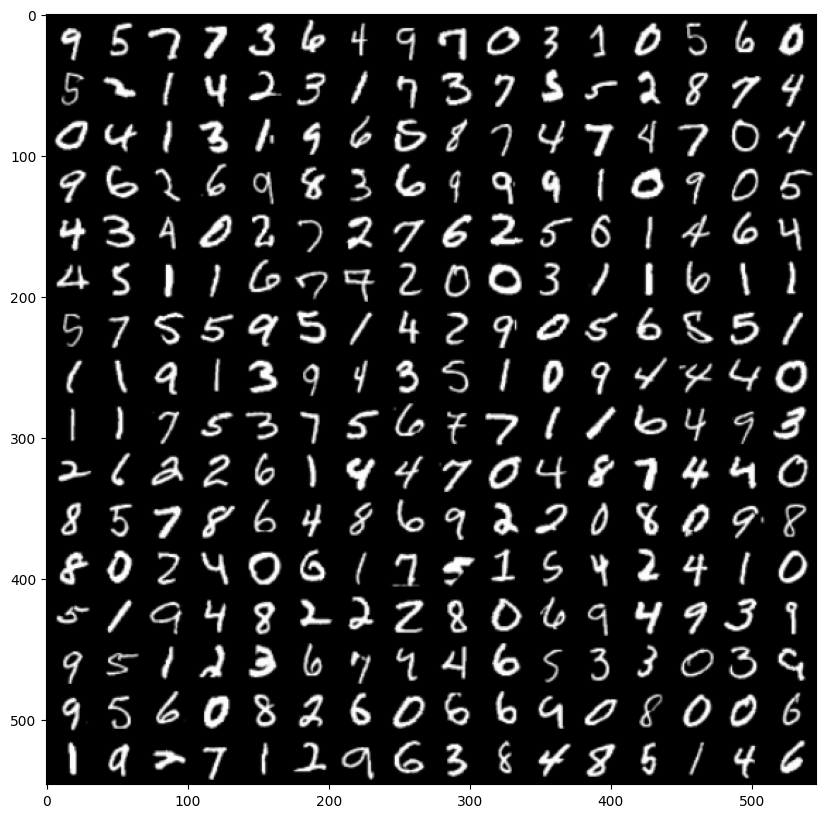

In [8]:
# Visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(data, nrow=16, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [9]:
class LeNet(LightningModule):
    def __init__(self, channels_in, output_size, loss_func, num_classes=10, learning_rate=1e-3):
        super().__init__()

        # Set the init args as class attributes
        self.learning_rate = learning_rate
        self.loss_fn = loss_func
        self.save_hyperparameters()

        # We'll use a torchmetrics "Accuracy" object to calculate the accuracies while training!
        self.test_accuracy = Accuracy(num_classes=num_classes, task='multiclass')
        self.train_accuracy = Accuracy(num_classes=num_classes, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=num_classes, task='multiclass')

        # Create Network
        # Define Convolution Layers
        # conv1 6 channels_inx5x5 kernels
        self.conv1 = nn.Conv2d(channels_in, 6, kernel_size=5)

        # conv2 16 6x5x5 kernels
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Define MaxPooling Layers
        # Default Stride is = to kernel_size
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Define Linear/Fully connected/ Dense Layers
        # Input to linear1 is the number of features from previous conv - 16x5x5
        # output of linear1 is 120
        self.linear1 = nn.Linear(16*5*5, 120)
        # output of linear2 is 84
        self.linear2 = nn.Linear(120, 84)
        # output of linear3 is 10
        self.linear3 = nn.Linear(84, output_size)

    def forward(self, x):
        # Pass input through conv layers
        # x shape is BatchSize-3-32-32

        x = F.relu(self.conv1(x))
        # out shape is BatchSize-6-28-28

        x = self.maxpool(x)
        # out shape is BatchSize-6-14-14

        x = F.relu(self.conv2(x))
        # out shape is BatchSize-16-10-10

        x = self.maxpool(x)
        # out2 shape is BatchSize-16-5-5

        # Flatten x to shape BatchSize-16x5x5
        x = x.view(x.shape[0], -1)

        x = F.relu(self.linear1(x))
        # out shape is BatchSize-120

        x = F.relu(self.linear2(x))
        # out4 shape is BatchSize-84

        x = self.linear3(x)
        # out5 shape is BatchSize-Output_Size

        return x

    # Using custom or multiple metrics (default_hp_metric=False)
    def on_train_start(self):
        self.logger.log_hyperparams(self.hparams, {"hp/val_acc": 0, "hp/train_acc": 0})

    def training_step(self, batch, batch_idx):
        # define a single training step
        # all this function needs to do is perform a forward pass and calculate the loss
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)

        train_dict = {"train_loss": loss,
                      "train_acc": self.train_accuracy.compute(),
                      "step": self.current_epoch}

        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)
        self.log("hp/train_acc", self.train_accuracy.compute())

        if self.current_epoch == 0 and batch_idx == 0:
            self.logger.experiment.add_graph(self, x)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)

        val_dict = {"val_loss": loss,
                    "val_acc": self.val_accuracy.compute(),
                    "step": self.current_epoch}

        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
        self.log("hp/val_acc", self.val_accuracy.compute())

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        test_dict = {"test_loss": loss,
                     "test_acc": self.test_accuracy.compute(),
                     "step": self.current_epoch}

        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return data_loader_train

    def val_dataloader(self):
        return data_loader_test

    def test_dataloader(self):
        return data_loader_test

In [10]:
lr_list = [2e-4, 4e-4, 8e-4, 1.6e-3, 3.2e-3, 6.4e-3]

for lr in lr_list:
    checkpoint_callback = ModelCheckpoint(monitor="val_acc",
                                          dirpath="MNIST_LeNet/",
                                          save_top_k=1,
                                          mode="max",
                                          every_n_epochs=1)

    model = LeNet(channels_in=1, output_size=10, loss_func=nn.CrossEntropyLoss(), learning_rate=lr)

    trainer = Trainer(accelerator = "auto",
                      # devices = 1 if torch.cuda.is_available() else None,
                      max_epochs = num_epochs,
                      callbacks = [TQDMProgressBar(refresh_rate=20), checkpoint_callback],
                      logger = TensorBoardLogger(save_dir="MNIST_LeNet", default_hp_metric=False),)

    trainer.fit(model)
    trainer.test(model)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/MNIST_LeNet exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summ

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │           20.0            │
│         test_acc          │    0.9843389391899109     │
│         test_loss         │    0.03631005808711052    │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | loss_fn        | CrossEntropyLoss   | 0     
1 | test_accuracy  | MulticlassAccuracy | 0     
2 | train_accuracy | MulticlassAccuracy | 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │           20.0            │
│         test_acc          │    0.9856258630752563     │
│         test_loss         │   0.037238869816064835    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | loss_fn        | CrossEntropyLoss   | 0     
1 | test_accuracy  | MulticlassAccuracy | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | conv1          | Conv2d             | 156   
5 | conv2          | Conv2d             | 2.4 K 
6 | maxpool        | MaxPool2d          | 0     
7 | linear1        | Linear             | 48.1 K
8 | linear2        | Linear             | 10.2 K


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │           20.0            │
│         test_acc          │    0.9880698323249817     │
│         test_loss         │    0.03186245262622833    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | loss_fn        | CrossEntropyLoss   | 0     
1 | test_accuracy  | MulticlassAccuracy | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | conv1          | Conv2d             | 156   
5 | conv2          | Conv2d             | 2.4 K 
6 | maxpool        | MaxPool2d          | 0     
7 | linear1        | Linear             | 48.1 K
8 | linear2        | Linear             | 10.2 K


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │           20.0            │
│         test_acc          │    0.9878851771354675     │
│         test_loss         │    0.04112950712442398    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | loss_fn        | CrossEntropyLoss   | 0     
1 | test_accuracy  | MulticlassAccuracy | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | conv1          | Conv2d             | 156   
5 | conv2          | Conv2d             | 2.4 K 
6 | maxpool        | MaxPool2d          | 0     
7 | linear1        | Linear             | 48.1 K
8 | linear2        | Linear             | 10.2 K


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │           20.0            │
│         test_acc          │     0.983751654624939     │
│         test_loss         │   0.052715349942445755    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | loss_fn        | CrossEntropyLoss   | 0     
1 | test_accuracy  | MulticlassAccuracy | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | conv1          | Conv2d             | 156   
5 | conv2          | Conv2d             | 2.4 K 
6 | maxpool        | MaxPool2d          | 0     
7 | linear1        | Linear             | 48.1 K
8 | linear2        | Linear             | 10.2 K


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           step            │           20.0            │
│         test_acc          │    0.9879049062728882     │
│         test_loss         │   0.046304941177368164    │
└───────────────────────────┴───────────────────────────┘